In [ ]:
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 k

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# import yolov5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
import time
from torchvision.utils import draw_bounding_boxes
#from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, AutoImageProcessor, DefaultDataCollator
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tqdm

In [ ]:
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Nuclear IT Hack

/content/drive/My Drive/Colab Notebooks/Nuclear IT Hack


In [ ]:
!unzip dataset_1.zip

In [ ]:
!unzip dataset-20240420T133215Z-001

#Считывание исходного датасета

In [ ]:
smokers_path = sorted(list(map(str, Path("./smokers").glob("*.jpg"))))
non_smokers_path = sorted(list(map(str, Path("./non_smokers").glob("*.jpg"))))
labels = []
for i, path in enumerate(smokers_path):
    with Image.open(path) as img:
        if i == 0:
            img = img.resize((640, 640))
            data = np.asarray(img).reshape(1, 640,640,3)
            labels.append("smoker")
        else:
            img = img.resize((640, 640))
            data = np.concatenate((data, np.asarray(img).reshape(1,640,640,3)), axis=0)
for path in non_smokers_path:
    with Image.open(path) as img:
        img = img.resize((640, 640))
        data = np.concatenate((data, np.asarray(img).reshape(1, 640,640,3)), axis=0)
        labels.append("non_smoker")

In [ ]:
DATA_MODES = ["train", "val"]
RESCALE_SIZE = 299
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
file_path_smoke = list(map(str, Path("./smokers").glob("*.jpg")))
file_path_non = list(map(str, Path("./people").glob("*.jpg")))
train_val_labels = [1] * len(file_path_smoke) + [0] * len(file_path_non)
file_path = file_path_smoke + file_path_non

In [ ]:
len(train_val_labels)

181

In [ ]:
class SmokersDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, labels):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.labels = labels

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        # if list(x.shape) != [640, 640, 3]:
        #     print(self.files[index], x.shape)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(file_path, train_val_labels, test_size=0.25, \
                                          stratify=train_val_labels)

#Подготовка модели детекции

In [ ]:
model = yolov5.load('yolov5l6.pt')

In [ ]:
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image
model.classes = 0

In [ ]:
tic = time.time()
out = model("/content/example1.jpg")
toc = time.time()
print(f"Prosses time: {(toc - tic) * 1000} ms")

Prosses time: 267.2383785247803 ms


In [ ]:
crop_img = out.crop(save=False)

In [ ]:
out.xyxy[0][0][:4].reshape(1,4).shape

torch.Size([1, 4])

In [ ]:
bbox = draw_bounding_boxes(torch.tensor(np.moveaxis(data[0], 2, 0)), out.xyxy[0][0][:4].reshape(1,4))

In [ ]:
bbox.shape

torch.Size([3, 640, 640])

In [ ]:
image = Image.fromarray(np.moveaxis(np.array(bbox), 0, 2))

In [ ]:
for i in range(data.shape[0]):
    out = model(data[i])


#Тренировка классификатора

In [ ]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
labels = ['smoker', 'non_smoker']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
class_model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    from_pt=False
)

In [ ]:
class_model.init_weights()

Linear(in_features=768, out_features=2, bias=True)

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

#InceptionV3

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs).logits
        #outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()
        processed_size += inputs.size(0)
        # print(f"labels: {labels}")
        # print(f"preds: {preds}")
    val_loss = running_loss / processed_size
    val_acc = running_corrects / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm.tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=5e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            # if (history[-1][3] > history[-2][3]):
            #     best_parameters = model.parameters()
            torch.cuda.empty_cache()
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
val_dataset = SmokersDataset(val_files, mode='val', labels=val_labels)

train_dataset = SmokersDataset(train_files, mode='train', labels=train_labels)

In [ ]:
my_inception_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
my_inception_v3.fc = nn.Linear(2048, 2)

In [ ]:
for params in list(my_inception_v3.parameters())[:-7]:
    params.requires_grad = False

In [ ]:
my_inception_v3.to(DEVICE)
1

1

In [ ]:
history = train(train_dataset, val_dataset, model=my_inception_v3, epochs=7, batch_size=32)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

loss 0.617126284926026


epoch:  14%|█▍        | 1/7 [00:07<00:46,  7.72s/it]


Epoch 001 train_loss: 0.6171     val_loss 0.5678 train_acc 0.6148 val_acc 0.6739
loss 0.4441389889628799


epoch:  29%|██▊       | 2/7 [00:14<00:37,  7.45s/it]


Epoch 002 train_loss: 0.4441     val_loss 0.3978 train_acc 0.7481 val_acc 0.7391
loss 0.325719983820562


epoch:  43%|████▎     | 3/7 [00:23<00:30,  7.71s/it]


Epoch 003 train_loss: 0.3257     val_loss 0.3459 train_acc 0.8963 val_acc 0.8913
loss 0.29375301202138265


epoch:  57%|█████▋    | 4/7 [00:32<00:25,  8.53s/it]


Epoch 004 train_loss: 0.2938     val_loss 0.3212 train_acc 0.9259 val_acc 0.8913
loss 0.24653523100747002


epoch:  71%|███████▏  | 5/7 [00:40<00:16,  8.35s/it]


Epoch 005 train_loss: 0.2465     val_loss 0.3028 train_acc 0.9333 val_acc 0.8913
loss 0.1967364094875477


epoch:  86%|████████▌ | 6/7 [00:48<00:08,  8.02s/it]


Epoch 006 train_loss: 0.1967     val_loss 0.3111 train_acc 0.9704 val_acc 0.8696
loss 0.15954008588084467


epoch: 100%|██████████| 7/7 [00:54<00:00,  7.81s/it]


Epoch 007 train_loss: 0.1595     val_loss 0.3072 train_acc 0.9630 val_acc 0.8913


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

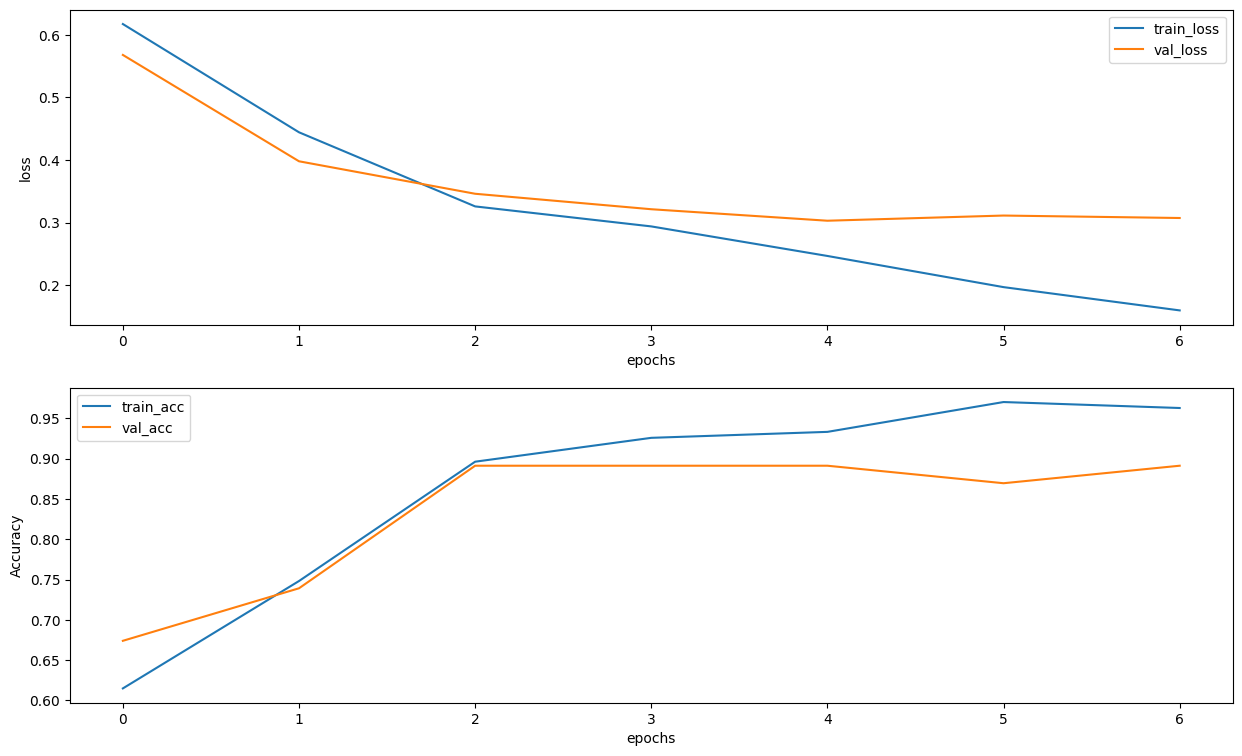

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
ax[0].plot(loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend(loc='best')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(acc, label="train_acc")
ax[1].plot(val_acc, label="val_acc")
ax[1].legend(loc='best')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
idxs = list(range(val_dataset.len_))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
actual_labels = [val_dataset[id][1] for id in idxs]
probs_ims = predict(my_inception_v3, imgs)
y_pred = np.argmax(probs_ims,-1)

In [ ]:
correct = np.sum(np.array(actual_labels) == np.array(y_pred)) / len(y_pred)
correct

0.8913043478260869

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.8913043478260869


#AlexNet

In [ ]:
my_alex = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
my_alex

In [ ]:
my_alex.classifier[4] = nn.Linear(4096, 2048)
my_alex.classifier[6] = nn.Linear(2048, 2)

In [ ]:
len(list(my_alex.parameters()))

16

In [ ]:
for params in list(my_inception_v3.parameters())[:-3]:
    params.requires_grad = False

In [ ]:
my_alex.to(DEVICE)
1

1

In [ ]:
history = train(train_dataset, val_dataset, model=my_alex, epochs=10, batch_size=32)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9))
ax[0].plot(loss, label="train_loss")
ax[0].plot(val_loss, label="val_loss")
ax[0].legend(loc='best')
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")

ax[1].plot(acc, label="train_acc")
ax[1].plot(val_acc, label="val_acc")
ax[1].legend(loc='best')
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

In [ ]:
len(val_files)

46

In [ ]:
idxs = list(range(val_dataset.len_))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
actual_labels = [val_dataset[id][1] for id in idxs]
probs_ims = predict(my_alex, imgs)
y_pred = np.argmax(probs_ims,-1)

In [ ]:
correct = np.sum(np.array(actual_labels) == np.array(y_pred)) / len(y_pred)
correct

0.7608695652173914

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.7608695652173914


#Инференс

In [ ]:
classificator = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
#Использовать model.parameters()

In [ ]:
def save_weights(path, model):
    pass

def load_weights(path, model):
    pass

In [ ]:
detector = yolov5.load('yolov5l6.pt')

detector.conf = 0.25  # NMS confidence threshold
detector.iou = 0.45  # NMS IoU threshold
detector.agnostic = False  # NMS class-agnostic
detector.multi_label = False  # NMS multiple labels per box
detector.max_det = 30  # maximum number of detections per image
detector.classes = 0

# classificator  = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
# classificator.fc = nn.Linear(2048, 2)

# load_weights(weights_path, classificator)

In [ ]:
example_image = Image.open(val_files[1])
example_image

In [ ]:
example_image = Image.open(train_files[1])

result = detector(example_image)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        y_pred = np.argmax(probs,-1)
    return y_pred

In [ ]:
Image.fromarray(result.crop(save=False)[0]['im'])

In [ ]:
result.crop(save=False)[0]['im'].shape

(5389, 1205, 3)

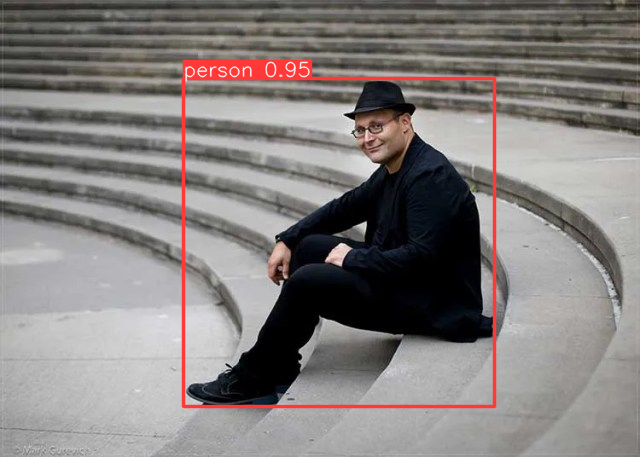

In [ ]:
result.show()

In [ ]:
example_image = Image.fromarray(result.crop(save=False)[0]['im'])
example_image = example_image.resize((RESCALE_SIZE, RESCALE_SIZE))
example_image = np.array(np.array(example_image) / 255, dtype='float32')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
example_image = transform(example_image)

predict_one_sample(my_inception_v3, example_image.unsqueeze(0), device=DEVICE)

array([0])